## 교통 데이터 기반 정체 여부 예측

- 사용 데이터: 서울 월별 교통속도 데이터 (2022~2024)
- 목적: 특정 시간·장소에서 정체가 발생할지를 예측
- 방식: 평균속도(SPD_AVG)를 기준으로 정체(1), 정상(0) 이진 분류
- 모델: Random Forest 분류기

In [2]:
import pandas as pd
import numpy as np

# CSV 불러오기
df = pd.read_csv("월별_교통속도_사본.csv")

# 정체 여부 생성 (평균속도 40km/h 미만이면 정체로 간주)
df['정체여부'] = (df['평균속도'] < 40).astype(int)

# 비율 확인
print(df['정체여부'].value_counts())

df


정체여부
0    48527
1     4554
Name: count, dtype: int64


,일자,CZN_CD,COCT_CD,교통량,평균속도,통행시간_분,NMLT_CSCNT,REVISN_CSCNT,통행시간_표준편차,통행시간_변화계수,...,F15T85_PASNG_RUNTM_QNTL,LAST_CHANGE_DAYHMINSEC,출발지,출발_위도,출발_경도,도착지,도착_위도,도착_경도,파일명,정체여부
0,202201,1040CZE030,1,-1,0.00,-1,0,0,0.00,0.00,...,0,20220201083056,서부산TG,35.156691,128.947064,가락IC,35.165139,128.896716,202201.csv,1
1,202201,1040CZS040,1,1218481,95.15,211,81353,7349,5.06,0.02,...,11,20220201083056,서부산IC,35.156004,128.951651,가락IC,35.165139,128.896716,202201.csv,0
2,202201,0100CZS290,1,979428,89.05,115,83196,5873,2.27,0.01,...,5,20220201083056,덕천IC,35.214906,129.008186,대저JC,35.219301,128.974349,202201.csv,0
3,202201,0100CZE285,1,883937,99.47,115,83318,5730,3.45,0.02,...,10,20220201083056,북부산TG,35.221307,128.940883,대저JC,35.219301,128.974349,202201.csv,0
4,202201,0550CZS020,1,-1,0.00,-1,0,0,0.00,0.00,...,0,20220201083056,초정IC,35.233765,128.980207,대저JC,35.219301,128.974349,202201.csv,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53076,202412,0141CZS190,1,3674,73.78,570,768,0,152.13,0.50,...,256,20250101083224,밀양JC,NaN,NaN,서밀양IC,NaN,NaN,202412.csv,0
53077,202412,0141CZS180,1,5776,74.38,779,806,2,159.52,0.31,...,213,20250101083224,서밀양IC,NaN,NaN,창녕JC,NaN,NaN,202412.csv,0
53078,202412,0141CZS170,1,-1,0.00,-1,126,0,0.00,0.00,...,0,20250101083224,창녕JC,NaN,NaN,함양울산선시점,NaN,NaN,202412.csv,1
53079,202412,0450CZE055,1,155959,91.38,411,14687,0,12.86,0.03,...,22,20250101083224,창녕JC,NaN,NaN,창녕IC,35.542562,128.476547,202412.csv,0


In [13]:
# 사용할 특성 정의
features = [
    '교통량', '통행시간_분', '통행시간_표준편차', '통행시간_변화계수',
    '일자', '출발_위도', '출발_경도', '도착_위도', '도착_경도'
]


# df_filtered => 결측치 제거
df_filtered = df[
    (df['교통량'] > 0) &
    (df['통행시간_분'] > 0) &
    (df['통행시간_표준편차'] > 0) &
    (df['평균속도'] > 0) &
    (df[features].notnull().all(axis=1))
]



In [18]:
# 데이터 불균형 해소: 정체(1) 데이터를 100배 복제하여 학습 균형 맞추기

# 정상 소통(정체여부=0)과 정체 발생(정체여부=1) 데이터 분리
정상 = df_filtered[df_filtered['정체여부'] == 0]
정체 = df_filtered[df_filtered['정체여부'] == 1]

# 정체 데이터 오버샘플링
정체_복제 = 정체.sample(n=3700, replace=True, random_state=42)

# 정상 데이터는 5000건만 랜덤 샘플링
정상_샘플 = 정상.sample(n=6300, random_state=42)

# 두 데이터 합쳐서 최종 학습용 데이터프레임 구성
df_balanced = pd.concat([정체_복제, 정상_샘플], ignore_index=True)

# 학습용 입력(X)과 정답(y) 정의
X = df_balanced[features]
y = df_balanced['정체여부']



In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [20]:
from sklearn.ensemble import RandomForestClassifier

# 모델 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 정확도 출력
print('훈련데이터 정확도: {:.2f}'.format(rf.score(X_train, y_train)))
print('테스트데이터 정확도: {:.2f}'.format(rf.score(X_test, y_test)))



훈련데이터 정확도: 1.00
테스트데이터 정확도: 1.00


In [21]:
# 시각화 설정
import matplotlib.pyplot as plt

# Windows 전용 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  
plt.rcParams['axes.unicode_minus'] = False     # 깨짐 방지


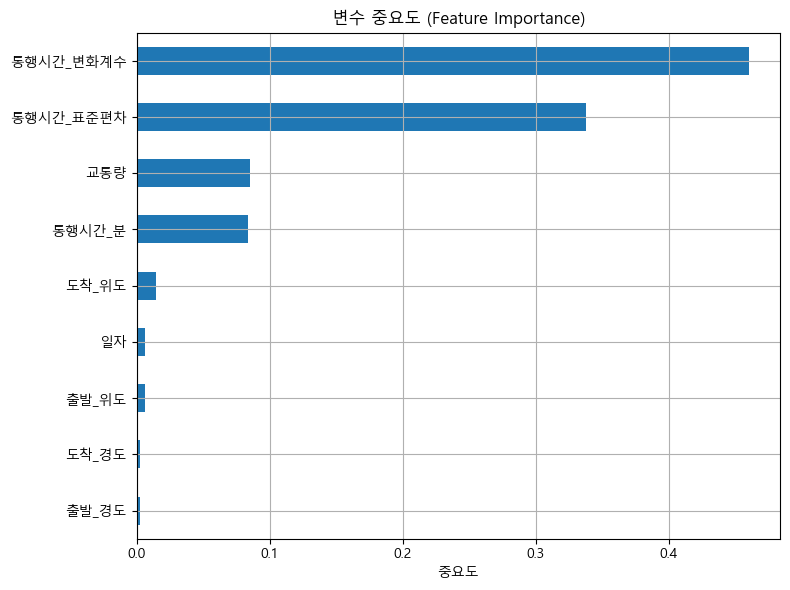

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# 변수 중요도 시각화
importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(8, 6))
importance.plot(kind='barh')
plt.title('변수 중요도 (Feature Importance)')
plt.xlabel('중요도')
plt.grid(True)
plt.tight_layout()
plt.show()


조회 + 분류 결과 확인

In [23]:
# 사용자가 입력한 도로명과 연월
start_name = '김천IC'
end_name = '동김천IC'
target_month = 202308  # 2023년 8월

# 해당 구간 + 월에 해당하는 데이터 1건 추출
query = (
    (df_filtered['출발지'] == start_name) &
    (df_filtered['도착지'] == end_name) &
    (df_filtered['일자'] == target_month)
)

# 표준편차 높은 것 우선 선택
future_row = df_filtered[query].sort_values('통행시간_표준편차', ascending=False).head(1)

if not future_row.empty:
    future_X = future_row[features]
    prediction = rf.predict(future_X)  # 모델 이름 수정
    print(f" 예측 결과: {start_name} → {end_name} 구간 ({target_month})")
    print("정체 발생" if prediction[0] == 1 else "정상 소통")
else:
    print("조건에 맞는 데이터가 없습니다.")


 예측 결과: 김천IC → 동김천IC 구간 (202308)
정상 소통


In [87]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf.predict(X_test)

print("\n 상세 평가:")
print(classification_report(y_test, y_pred))

#split 으로 7:3으로 분류 하였음애도 정확도가 1.0 이 나오는걸 볼수있다. 


 상세 평가:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1260
           1       1.00      1.00      1.00       740

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [81]:
import pandas as pd

# 미래 시점 도로 정보와 예측 시점
미래_예측_데이터 = {
    '교통량': 560000,
    '통행시간_분': 950,
    '통행시간_표준편차': 250,
    '통행시간_변화계수': 2.8,
    '일자': 202509,  # 미래 월
    '출발_위도': 36.1336,
    '출발_경도': 128.0947,
    '도착_위도': 44.1366,
    '도착_경도': 128.1770
}

#  사용한 feature 목록 
features = [
    '교통량', '통행시간_분', '통행시간_표준편차', '통행시간_변화계수',
    '일자', '출발_위도', '출발_경도', '도착_위도', '도착_경도'
]

#  입력값을 DataFrame으로 변환
future_df = pd.DataFrame([미래_예측_데이터])[features]

#  예측 수행
prediction = rf.predict(future_df)
proba = rf.predict_proba(future_df)[0]

#  결과 출력
print("결과:")
print(" 예측 출발지: 위도 {}, 경도 {}".format(미래_예측_데이터['출발_위도'], 미래_예측_데이터['출발_경도']))
print(" 예측 도착지: 위도 {}, 경도 {}".format(미래_예측_데이터['도착_위도'], 미래_예측_데이터['도착_경도']))
print(" 예측 시점: {}".format(미래_예측_데이터['일자']))
# 발생확률 

.................
........................
.....
print(f"정상 소통 확률: {proba[0]*100:.2f}%")
print(f"정체 발생 확률: {proba[1]*100:.2f}%")


결과:
 예측 출발지: 위도 36.1336, 경도 128.0947
 예측 도착지: 위도 44.1366, 경도 128.177
 예측 시점: 202509
정상 소통 확률: 25.00%
정체 발생 확률: 75.00%
